<a href="https://colab.research.google.com/github/mffg1993/TutorialsOnStructuredLight/blob/main/Python/HologramImplementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

##############################################################################################
# Hologram
####################################################################lo##########################

# Generation of holograms for almost whatever you want
def Hologram(A,hx,hy,LA):
    # A -> Complex amplitude of the beam
    # hx, hy
  # Normalization of the input beam

  nn=np.sum(np.abs(A)**2)*hx*hy
  NU=A/np.sqrt(nn)

  # Amplitude and phase pattern
  Amp=np.abs(NU)
  PHI=np.angle(NU)

  # Grating
  mm=Amp.shape
  x1,y1=np.meshgrid(hx*np.arange(1,mm[1]+1),hy*np.arange(1,mm[0]+1))

  # Inverse Sinc fucntion
  ss=np.linspace(-np.pi,0,2000)
  sincc=np.sin(ss)/ss
  sincc[np.isnan(sincc)]=1

  # Amplitude masking
  M=1+np.interp(Amp,sincc,ss)/np.pi
  M[np.isnan(M)]=0


  # Phase Hologram
  F=np.mod(PHI-np.pi*M+x1/LA,2*np.pi)

  # Full Hologram
  return M*F


## Generation of a Laguerre-Gaussian Hologram
def HoloLG(l,p,w0,z=(0,5),Z=(1,0,0,0),LA=0.09,maxx=1,SLM_Pix=(1024,780),position=(0,0)):
    rate=SLM_Pix[1]/SLM_Pix[0] # Assuming squared pixels
    maxy=rate*maxx; #Scaling of the Y axis

    # Space definition + displacements
    X=np.linspace(-maxx,maxx,SLM_Pix[0])+position[0];
    Y=-np.linspace(-maxy,maxy,SLM_Pix[1])+position[1];

    # Relevant stuff
    dx=np.abs(X[1]-X[2]);
    dy=np.abs(Y[1]-Y[2]);
    xx,yy=np.meshgrid(X,Y);
    r, phi= cart2pol(xx,yy)

    # Zernike Polynomial mask - Zorro no te lo lleves!
    ZPM=Zernike(r/Z[0],phi,Z[2],Z[3])

    # LG beam including the Zernike Polynomial stuff
    A=LG(r,phi,l,p,w0)*np.exp(1j*2*np.pi*Z[1]*ZPM)

    # Propagating the shit out of me :)
    if z[0]>0:
        # Propagation space
        ZZ=np.linspace(0,z[0],z[1])

        # Propagation steps
        dz=np.abs(ZZ[0]-ZZ[1])

        # Saving the field at every plane
        F=[A]

        for ii in range(0,nz):
            A=propTF(A,2*maxx,1,dz) # Field at plane z->z_0
            F.append(A)

    # Generation of the Hologram
    return([np.abs(A)**2,np.angle(A),Hologram(A,dx,dy,LA)])


##############################################################################################
# Zernike Polynomials
##############################################################################################


# Coeffcients and powers or the radial Polynomials
def RR(m,n):
  nm=n-m
  coeff=[]
  pow=[]
  if (n-m)%2==0:
    for kk in range(0,int(((n-m)/2+1))):
      aa=((-1)**kk*math.factorial(int(n-kk)))/(math.factorial(int(kk))*math.factorial(int((n+m)/2-kk))*math.factorial(int((n-m)/2-kk)))
      bb=n-2*kk
      coeff.append(aa)
      pow.append(bb)
  else:
    coeff.append(0)
    pow.append(0)
  return([coeff,pow])

# Construction of the polynomial
def Zernike(RHO,PHI,m,n):
  ZR=np.zeros(RHO.shape);
  rn=RR(np.abs(m),n)

  for ii in range(len(rn[0])):
    ZR=ZR+rn[0][ii]*RHO**rn[1][ii]

  if m>=0:
    Z=ZR*np.cos(np.abs(m)*PHI)
  else:
    Z=ZR*np.sin(np.abs(m)*PHI)
  M=(RHO<=1)
  P=Z*M
  P=(P-np.min(P))/np.max(P-np.min(P))
  return(P)


##############################################################################################
# Numerical implementation of the Special functions
##############################################################################################


# Numerical Implementation of the Laguerre Polynomials
def NlaguerreL(n,a,X):
  LL=0
  for m in range(n+1):
    LL=LL+((-1)**m)*(math.factorial(n+a))/(math.factorial(n-m)*math.factorial(a+m)*math.factorial(m))*(X**m);
  return(LL)

# Laguerre-Gaussian Beam where ell and p are the azimuthal and radial indexes, respectively
def LG(RHO,PHI,ell,p,w0):
    C=np.sqrt((2*math.factorial(p))/(np.pi*math.factorial(p+np.abs(ell))))*(1/w0)
    return(C*np.exp(-(RHO/w0)**2)*((np.sqrt(2)*RHO/w0)**np.abs(ell))*np.exp(1j*ell*PHI)*NlaguerreL(p,np.abs(ell),2*(RHO/w0)**2))

#Numerical definition of the Hermite Polynomials
def NHermite(n,X):
    Hn1=np.ones(X.shape);
    H=2*X;
    if n<0:
        print('The index must be 0 or positive')
    elif n==0:
        H=Hn1;
    elif n==1:
        H=H;
    else:
        for nn in range(2,n+1):
            Hn=2*X*H-2*(nn-1)*Hn1;
            Hn1=H;
            H=Hn;
    return(H)

# Hermite Gaussian beam where m and ell are the orders in the x and y direction, respectively
def HG(X,Y,m,n,w0):
    h=np.abs(X[0,0]-X[0,1])
    a=NHermite(m,np.sqrt(2)*X/w0)*NHermite(n,np.sqrt(2)*Y/w0)*np.exp(-(X**2+Y**2)/w0**2)
    N=np.sum(h*h*np.abs(a)**2)
    a=a/np.sqrt(N)
    return(a)

##############################################################################################
# Propagating my dreams a tiny step at the time
##############################################################################################

# Fresnel propagation using the Transfer function approach
# Based on Computational Fourier Optics by Voelz
# Generalization to non-square windows
#
# PARAMETERS
#
# u1      - Complex Amplitude of the beam at the source plane. It is a square array
# Lx       - Sidelength of the simulation window of the source plane in the X direction
# Ly       - Sidelength of the simulation window of the source plane in the X direction
# lambda  - Wavelength
# z       - Propagation distance
# u2      - Complex Amplitude of the beam at the observation plane

def propTF(u1,Lx,Ly,la,z):
  Yd,Xd=u1.shape
  dx=Lx/Xd
  dy=Ly/Yd
  fx=np.arange(-1/(2*dx),1/(2*dx),1/Lx)
  fy=np.arange(-1/(2*dy),1/(2*dy),1/Ly)
  Fx, Fy = np.meshgrid(fx, fy)
  #print(Fx.shape)
  #print(u1.shape)

  H=np.exp(-1j*np.pi*0.25*la*z*(Fx**2+Fy**2))


  U2=H*np.fft.fftshift(np.fft.fft2(u1))

  u2=np.fft.ifft2(np.fft.ifftshift(U2))
  return u2



##############################################################################################
# Manuel's toolbox for lazy people
##############################################################################################

# Cartesian to Polar coordinates
def cart2pol(x, y):
  rho = np.sqrt(x**2 + y**2)
  phi = np.arctan2(y, x)
  return(rho, phi)


# Chopping as in Mathematica
def Chop(A):
    return(np.real(A)*(np.abs(np.real(A)>1e-8))+np.imag(A)*(np.abs(np.imag(A)>1e-8)))






This is a generalization of the code that I made to generate the holograms. In this case The function **Holo_Generalized**, generates the hologram for a LG mode at the plane z=0:
```
Holo_Generalized(A_init,w0,maxx=1,position=(0,0),SLM_Pix=(1024,780),LA=0.09,Z=(1,0,0,0),z=(0,5))
```
where the parameters are given by:

*   **A_init** is the initial beam shape
*   **w0** is the waist parameter of the LG mode
*   **maxx** is half-lenght of the SLM in the horizontal direcion (BETA)
*   **position=(x0,y0)** is a tuple that indicates the new beam's centre. It is considered as (0,0) if none is given.
*   **SLM_Pix** is a tuple that considers the pixel size of the SLM. It takes (1024,780) as default if none is given.
*   **LA** is a positive number that indicates the periodicity of the hologram grating. It takes LA=0.09 as default if none is given.
*   **Z(aperture,strength,m,n)** is a tuple that indicates the parameters of the phase mask that contains the Zernike Polynomials. It takes (aperture=1,strength=0,m=0,n=0) as default if none is given.
*   **z(total_distance,z_steps)** is a tuple that indicates the parameters of the Fresnel propagation. It takes (0,5) as default if none is given.  


In [ ]:
#Nazanin Generalized Hologram Function

def Holo_Generalized(A_init,w0,z=(0,5),Z=[(1,0,0,0)],LA=0.09,maxx=1,SLM_Pix=(1024,780),center=(0,0)):
    rate=SLM_Pix[1]/SLM_Pix[0] # Assuming squared pixels
    maxy=rate*maxx; #Scaling of the Y axis

    # Space definition + displacements
    X=np.linspace(-maxx,maxx,SLM_Pix[0])+center[0];
    Y=-np.linspace(-maxy,maxy,SLM_Pix[1])+center[1];

    # Relevant stuff
    dx=np.abs(X[1]-X[2]);
    dy=np.abs(Y[1]-Y[2]);
    xx,yy=np.meshgrid(X,Y);
    r, phi= cart2pol(xx,yy)

    A = A_init

    for i in range(len(Z)):
        # Zernike Polynomial mask - Zorro no te lo lleves!
        ZPM = Zernike(r/Z[i][0],phi,Z[i][2],Z[i][3])

        # LG beam including the Zernike Polynomial stuff
        A = A * np.exp(1j*2*np.pi*Z[i][1]*ZPM)

    # Propagating the shit out of me :)
    if z[0]>0:
        # Propagation space
        ZZ=np.linspace(0,z[0],z[1])

        # Propagation steps
        dz=np.abs(ZZ[0]-ZZ[1])

        # Saving the field at every plane
        F=[A]

        for ii in range(0,nz):
            A=propTF(A,2*maxx,1,dz) # Field at plane z->z_0
            F.append(A)

    # Generation of the Hologram
    return([np.abs(A)**2,np.angle(A),Hologram(A,dx,dy,LA)])

def Combined_Hologram_Generator(A1,A2,LA,maxx,SLM_Pix,center1,center2,Z1,Z2):

    W = SLM_Pix[0]/2
    L = SLM_Pix[1]

    Amp1,PH1,Hol1=HoloLG(A1,0.4,LA=0.04,maxx=2,SLM_Pix=(W,L),center1=(0.5,0),Z=Z1);
    Amp2,PH2,Hol2=HoloLG(A2,0.4,LA=0.04,maxx=2,SLM_Pix=(W,L),center2=(0.5,0),Z=Z2);

    AmpC=np.concatenate((Amp1,Amp2),axis=1)
    PHC=np.concatenate((PH1,PH2),axis=1)
    HolC=np.concatenate((Hol1,Hol2),axis=1)

    return(AmpC,PHC,HolC)


# Laguerre Gaussian Beam in a square grid

<ipython-input-5-58c7b3093ceb>:28: RuntimeWarning: invalid value encountered in divide
  sincc=np.sin(ss)/ss


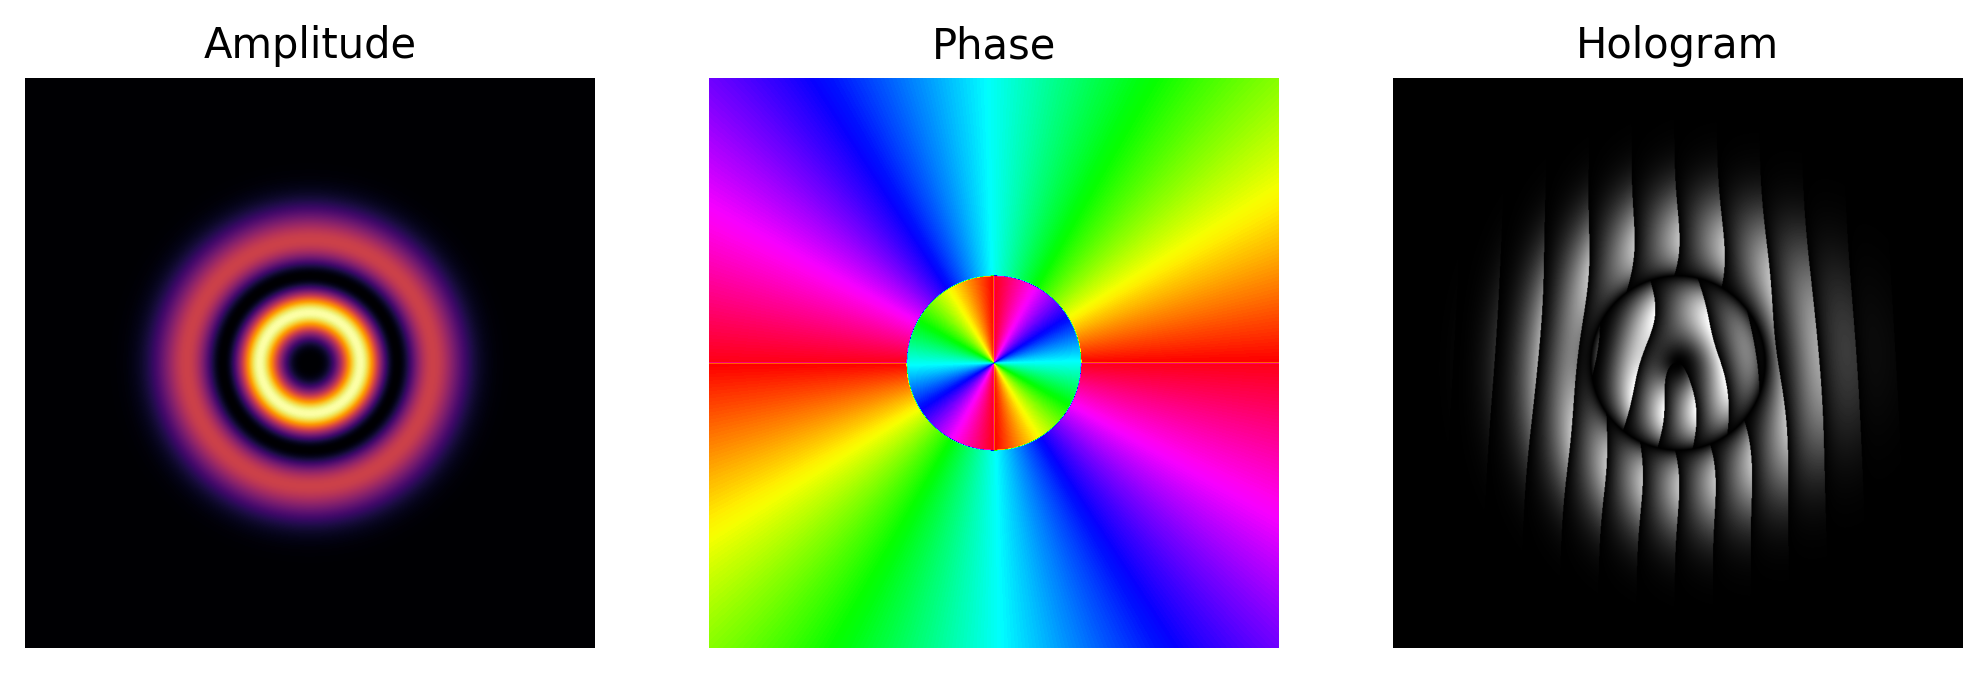

In [ ]:
# Beam profile

k=2*np.pi  # [m^-1] wavenumber         # [mm] beam waist
maxx=4       # [units of w0] Half length of the numerical window
N=1024        # [Number of points per dimension]
                # For fast results, consider using an square matrix and N to be a power of 2
# Space definition
X=np.linspace(-maxx,maxx,N);
Y=-np.linspace(-maxx,maxx,N);

h=np.abs(X[1]-X[2]);
xx,yy=np.meshgrid(X,Y);
r, phi= cart2pol(xx,yy)

A=LG(r,phi,2,1,1)
LA = 0.09

# Hologram calculation
Hol1=Hologram(A,h,h,LA)

plt.figure(figsize=(10,10),dpi=250)
plt.subplot(131)
plt.imshow(np.abs(A)**2,cmap="inferno")
plt.title('Amplitude')
plt.axis('off')

plt.subplot(132)
plt.imshow(np.angle(A),cmap='hsv')
plt.title('Phase')
plt.axis('off')

plt.subplot(133)
plt.imshow(Hol1,cmap='gray')
plt.title('Hologram')
plt.axis('off')
plt.show()

In [ ]:
Chop(Hol1)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Hermite Gaussian Beam in a square grid

<ipython-input-1-e21835cc1a28>:28: RuntimeWarning: invalid value encountered in divide
  sincc=np.sin(ss)/ss


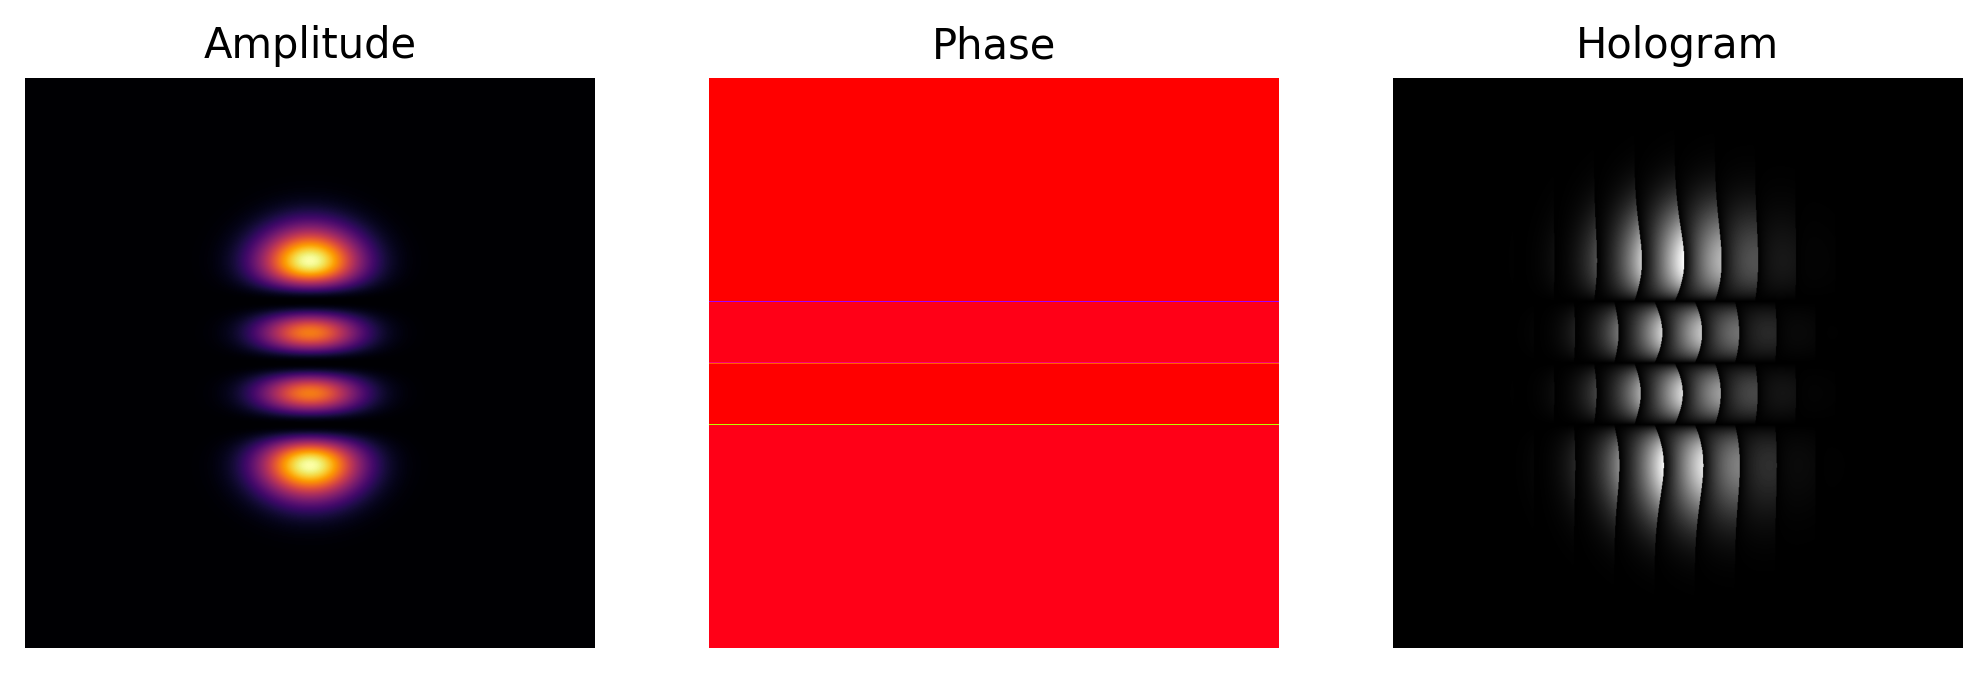

In [ ]:
k=2*np.pi  # [m^-1] wavenumber         # [mm] beam waist
maxx=4       # [units of w0] Half length of the numerical window
N=1024        # [Number of points per dimension]
                # For fast results, consider using an square matrix and N to be a power of 2
# Space definition
X=np.linspace(-maxx,maxx,N);
Y=-np.linspace(-maxx,maxx,N);

h=np.abs(X[1]-X[2]);
xx,yy=np.meshgrid(X,Y);
r, phi= cart2pol(xx,yy)

A=HG(xx,yy,0,3,1)
# Hologram calculation
Hol1=Hologram(A,h,h,LA)

plt.figure(figsize=(10,10),dpi=250)
plt.subplot(131)
plt.imshow(np.abs(A)**2,cmap="inferno")
plt.title('Amplitude')
plt.axis('off')

plt.subplot(132)
plt.imshow(np.angle(A),cmap='hsv')
plt.title('Phase')
plt.axis('off')

plt.subplot(133)
plt.imshow(Hol1,cmap='gray')
plt.title('Hologram')
plt.axis('off')
plt.show()

# Trefoil Beam

<ipython-input-1-e21835cc1a28>:28: RuntimeWarning: invalid value encountered in divide
  sincc=np.sin(ss)/ss


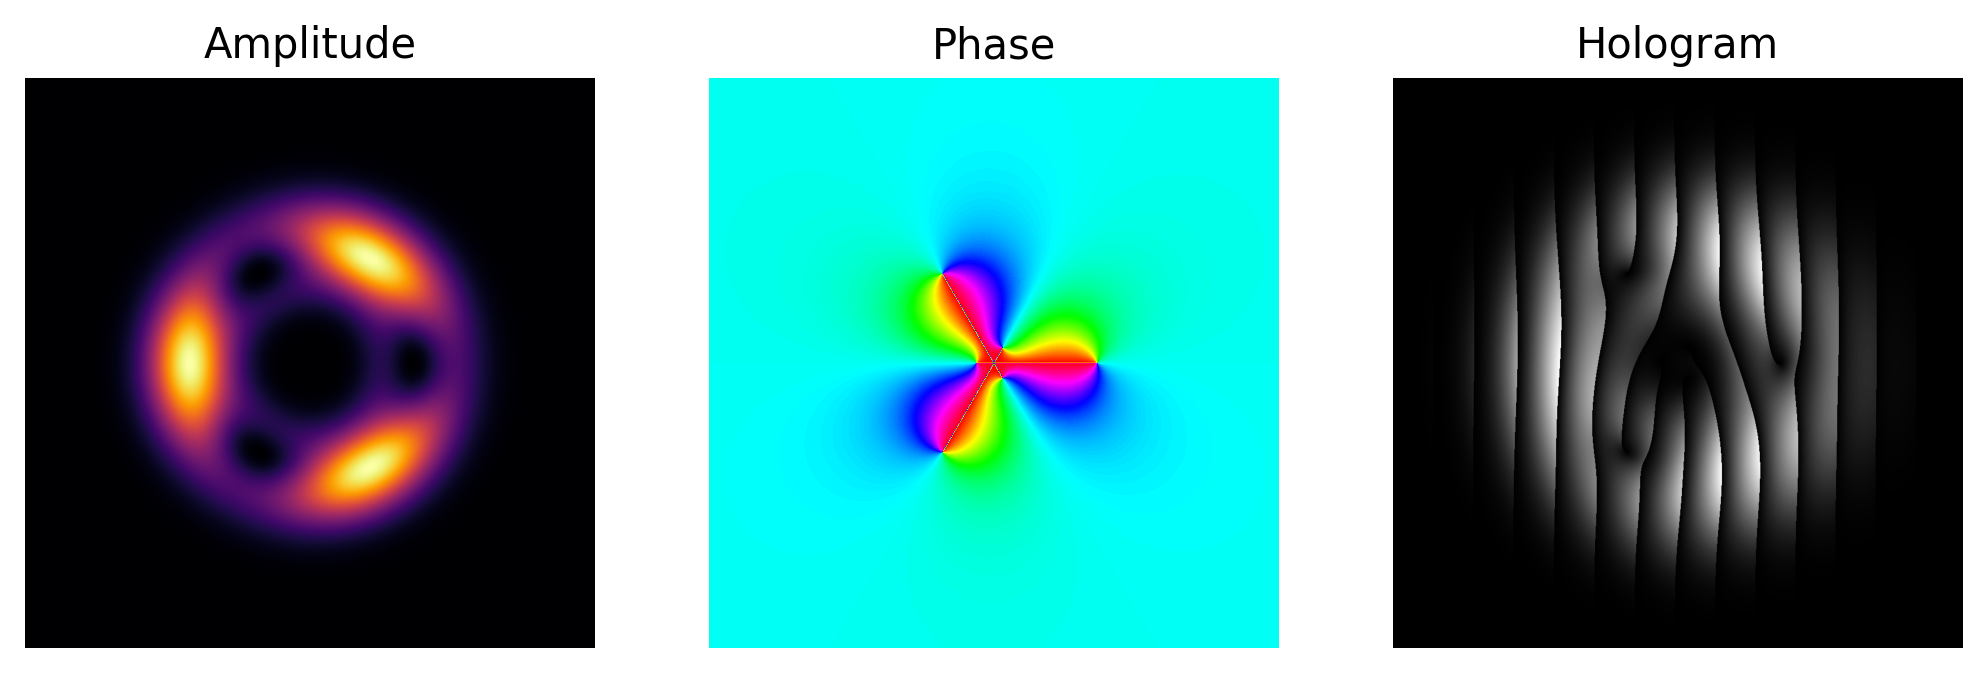

In [ ]:
k=2*np.pi  # [m^-1] wavenumber         # [mm] beam waist
maxx=4       # [units of w0] Half length of the numerical window
N=1024        # [Number of points per dimension]
                # For fast results, consider using an square matrix and N to be a power of 2
# Space definition
X=np.linspace(-maxx,maxx,N);
Y=-np.linspace(-maxx,maxx,N);

h=np.abs(X[1]-X[2]);
xx,yy=np.meshgrid(X,Y);
r, phi= cart2pol(xx,yy)

kk = 1.2
a = 1
b = 1
r = r/0.6
# Input Beam profile
A=np.exp(-(r/(np.sqrt(2)*kk))**2)*((-1 + r**2)**3 - 8 * r**3 * (a * np.cos(phi) + 1j * b * np.sin(phi))**3)

# Hologram calculation
Hol1=Hologram(A,h,h,LA)

plt.figure(figsize=(10,10),dpi=250)
plt.subplot(131)
plt.imshow(np.abs(A)**2,cmap="inferno")
plt.title('Amplitude')
plt.axis('off')

plt.subplot(132)
plt.imshow(np.angle(A),cmap='hsv')
plt.title('Phase')
plt.axis('off')

plt.subplot(133)
plt.imshow(Hol1,cmap='gray')
plt.title('Hologram')\
plt.axis('off')
plt.show()

<ipython-input-1-e21835cc1a28>:28: RuntimeWarning: invalid value encountered in divide
  sincc=np.sin(ss)/ss


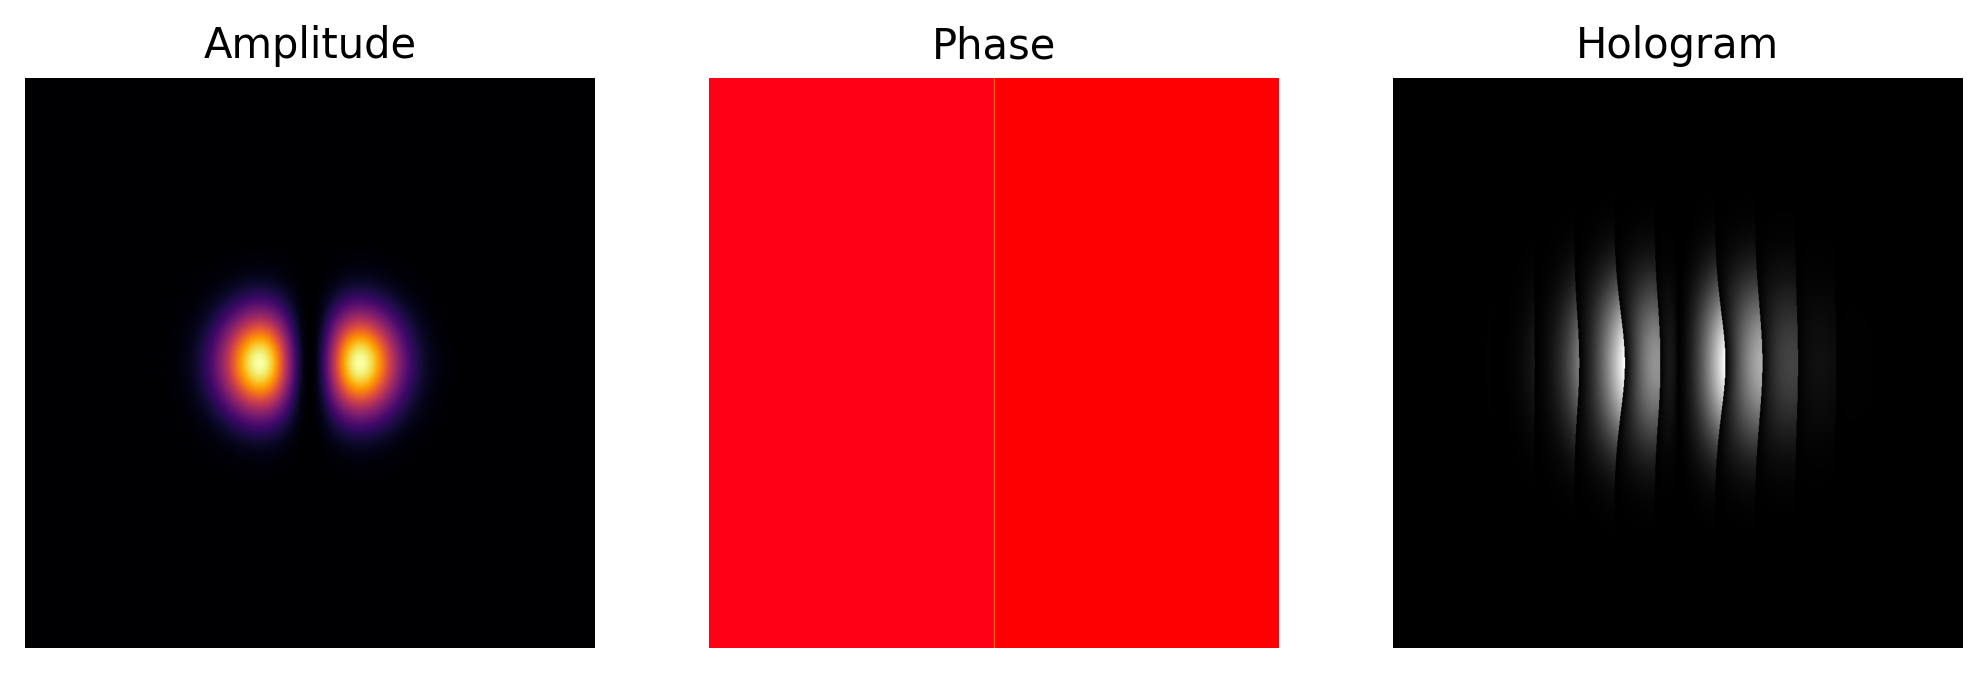

In [ ]:
k=2*np.pi  # [m^-1] wavenumber         # [mm] beam waist
maxx=4       # [units of w0] Half length of the numerical window
N=1024        # [Number of points per dimension]
                # For fast results, consider using an square matrix and N to be a power of 2
# Space definition
X=np.linspace(-maxx,maxx,N);
Y=-np.linspace(-maxx,maxx,N);

h=np.abs(X[1]-X[2]);
xx,yy=np.meshgrid(X,Y);
r, phi= cart2pol(xx,yy)

LA = 0.09

# Input Beam profile
A=LG(r,phi,1,0,1)+LG(r,phi,-1,0,1)

# Hologram calculation
Hol1=Hologram(A,h,h,LA)

plt.figure(figsize=(10,10),dpi=250)
plt.subplot(131)
plt.imshow(np.abs(A)**2,cmap="inferno")
plt.title('Amplitude')
plt.axis('off')

plt.subplot(132)
plt.imshow(np.angle(A),cmap='hsv')
plt.title('Phase')
plt.axis('off')

plt.subplot(133)
plt.imshow(Hol1,cmap='gray')
plt.title('Hologram')
plt.axis('off')
plt.show()

# Let's go non square


This is a generalization of the code that I made to generate the holograms. In this case The function **HoloLG**, generates the hologram for a LG mode at the plane z=0:
```
HoloLG(l,p,w0,maxx=1,position=(0,0),SLM_Pix=(1024,780),LA=0.09,Z=(1,0,0,0),z=(0,5))
```
where the parameters are given by:

*   **l** is the topological charge of the LG mode
*   **p** is the radial index of the LG mode
*   **w0** is the waist parameter of the LG mode
*   **maxx** is half-lenght of the SLM in the horizontal direcion (BETA)
*   **position=(x0,y0)** is a tuple that indicates the new beam's centre. It is considered as (0,0) if none is given.
*   **SLM_Pix** is a tuple that considers the pixel size of the SLM. It takes (1024,780) as default if none is given.
*   **LA** is a positive number that indicates the periodicity of the hologram grating. It takes LA=0.09 as default if none is given.
*   **Z(aperture,strength,m,n)** is a tuple that indicates the parameters of the phase mask that contains the Zernike Polynomials. It takes (aperture=1,strength=0,m=0,n=0) as default if none is given.
*   **z(total_distance,z_steps)** is a tuple that indicates the parameters of the Fresnel propagation. It takes (0,5) as default if none is given.  


<ipython-input-2-58c7b3093ceb>:28: RuntimeWarning: invalid value encountered in divide
  sincc=np.sin(ss)/ss


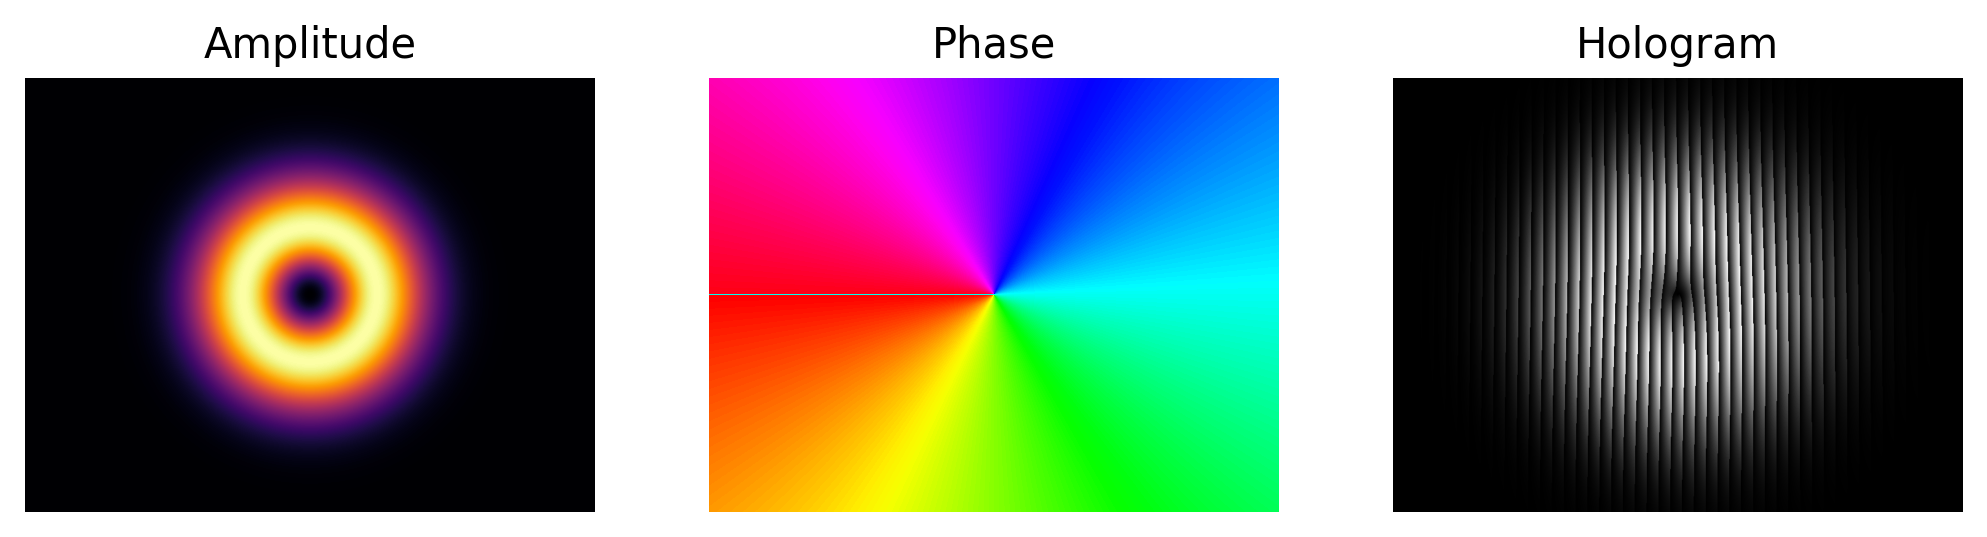

In [ ]:
# Hologram of a LG mode l=1 p=0

Amp,PH,Hol=HoloLG(1,0,1,LA=0.02,maxx=3,SLM_Pix=(1024,780));

plt.figure(figsize=(10,10),dpi=250)
plt.subplot(131)
plt.imshow(Amp,cmap="inferno")
plt.title('Amplitude')
plt.axis('off')

plt.subplot(132)
plt.imshow(PH,cmap='hsv')
plt.title('Phase')
plt.axis('off')

plt.subplot(133)
plt.imshow(Hol,cmap='gray')
plt.title('Hologram')
plt.axis('off')
plt.show()



In [ ]:
# Hologram of a LG mode l=1 p=0, displaced by 0.7 units in the x axis

Amp,PH,Hol=HoloLG(1,0,1,LA=0.09,maxx=3,SLM_Pix=(1920,1380),position=(0.7,0));

plt.figure(figsize=(10,10),dpi=250)
plt.subplot(131)
plt.imshow(Amp,cmap="inferno")
plt.title('Amplitude')
plt.axis('off')

plt.subplot(132)
plt.imshow(PH,cmap='hsv')
plt.title('Phase')
plt.axis('off')

plt.subplot(133)
plt.imshow(Hol,cmap='gray')
plt.title('Hologram')
plt.axis('off')
plt.show()



In [ ]:
# Hologram of a LG mode l=1 p=0, displaced by 0.7 units in the x axis with a smaller waist and smaller periodicity

Amp,PH,Hol=HoloLG(1,0,0.5,LA=0.02,maxx=3,SLM_Pix=(1920,1380),position=(0.7,0));

plt.figure(figsize=(10,10),dpi=250)
plt.subplot(131)
plt.imshow(Amp,cmap="inferno")
plt.title('Amplitude')
plt.axis('off')

plt.subplot(132)
plt.imshow(PH,cmap='hsv')
plt.title('Phase')
plt.axis('off')

plt.subplot(133)
plt.imshow(Hol,cmap='gray')
plt.title('Hologram')
plt.axis('off')
plt.show()


In [ ]:
# Hologram of a LG mode l=1 p=0, displaced by 0.5 units in the x axis with a smaller waist and smaller periodicity and Zernike(2,2) mask of gamma=0.8, aperture size of 1
Amp,PH,Hol=HoloLG(1,0,0.4,LA=0.04,maxx=3,SLM_Pix=(1920,1380),position=(1.5,1.5),Z=(1,0.8,2,2));

plt.figure(figsize=(10,10),dpi=250)
plt.subplot(131)
plt.imshow(Amp,cmap="inferno")
plt.title('Amplitude')
plt.axis('off')

plt.subplot(132)
plt.imshow(PH,cmap='hsv')
plt.title('Phase')
plt.axis('off')

plt.subplot(133)
plt.imshow(Hol,cmap='gray')
plt.title('Hologram')
plt.axis('off')
plt.show()

# Dividing the Hologram in 2

A composed Hologram can be done by Concatenating the 2 different Hologram arrays

In [ ]:
#Composed Hologram
Amp1,PH1,Hol1=HoloLG(1,0,0.4,LA=0.04,maxx=2,SLM_Pix=(960,1380),position=(0.5,0),Z=(1,0.8,2,2));
Amp2,PH2,Hol2=HoloLG(1,1,0.4,LA=0.04,maxx=2,SLM_Pix=(960,1380),position=(0.5,0),Z=(1,0,2,2));

AmpC=np.concatenate((Amp1,Amp2),axis=1)
PHC=np.concatenate((PH1,PH2),axis=1)
HolC=np.concatenate((Hol1,Hol2),axis=1)

plt.figure(figsize=(10,10),dpi=250)
plt.subplot(131)
plt.imshow(AmpC,cmap="inferno")
plt.title('Amplitude')
plt.axis('off')

plt.subplot(132)
plt.imshow(PHC,cmap='hsv')
plt.title('Phase')
plt.axis('off')

plt.subplot(133)
plt.imshow(HolC,cmap='gray')
plt.title('Hologram')
plt.axis('off')
plt.show()

# Introducing a Fresnel propagator

In [ ]:
Amp3,PH3,Hol3=HoloLG(1,1,0.2,LA=0.04,maxx=2,SLM_Pix=(960,1380),position=(0.2,0),Z=(1,0,2,2), z=(2,20))

In [ ]:
plt.figure(figsize=(10,10),dpi=250)
plt.subplot(131)
plt.imshow(Amp3,cmap="inferno")
plt.title('Amplitude')
plt.axis('off')

plt.subplot(132)
plt.imshow(PH3,cmap='hsv')
plt.title('Phase')
plt.axis('off')

plt.subplot(133)
plt.imshow(Hol3,cmap='gray')
plt.title('Hologram')
plt.axis('off')
plt.show()